In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import astropy as ap
from astropy.table import QTable

import read_mist_models

## Checking luminosity and radius

Checking if we can get the luminosity and the radius back from the data using formulas or if they also need to be predicted

In [7]:
def get_iso_data_panda(file):
    iso = read_mist_models.ISO(file)

    age = []
    logTeff = []
    logL = []
    log_g = []
    mass = []
    logR = []
    for iso_ind in range(len(iso.isos)):
        age.extend(iso.isos[iso_ind]['log10_isochrone_age_yr'])
        logTeff.extend(iso.isos[iso_ind]['log_Teff'])
        logL.extend(iso.isos[iso_ind]['log_L'])
        log_g.extend(iso.isos[iso_ind]['log_g'])
        mass.extend(iso.isos[iso_ind]['star_mass'])
        logR.extend(iso.isos[iso_ind]['log_R'])

    iso_data_all = QTable([age, logTeff, log_g, mass, logL, logR],
                        names=('age', 'logTeff', 'log_g', "mass", "logL", "logR"),
                        meta={'name': "iso data"})
    return iso_data_all.to_pandas()

In [8]:
full_data = get_iso_data_panda("data/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.txt")

Reading in: data/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.txt


In [9]:
display(full_data)

,age,logTeff,log_g,mass,logL,logR
0,5.0,3.468541,3.116651,0.100000,-0.849695,0.160747
1,5.0,3.469176,3.114042,0.101392,-0.839643,0.164503
2,5.0,3.471116,3.106133,0.105660,-0.808944,0.175973
3,5.0,3.473035,3.098417,0.109915,-0.778564,0.187325
4,5.0,3.474944,3.090875,0.114180,-0.748368,0.198605
...,...,...,...,...,...,...
103984,10.3,4.370643,7.779334,0.528715,-1.180793,-1.809005
103985,10.3,4.363336,7.782175,0.528717,-1.212858,-1.810425
103986,10.3,4.356026,7.784962,0.528720,-1.244886,-1.811817
103987,10.3,4.348711,7.787695,0.528724,-1.276875,-1.813182


In [10]:
R/R_0 = np.sqrt((M/M_0) * 10**(log_g_0 - log_g))
# M/M_0 = val colonne "mass", log_g_0 = 4.4381, log_g = val colonne "log_g"
# -> on a le rayon en rayon solaire => se vérifie avec 10**ce qu'il y a dans la colonne "logR"

L/L_0 = (R/R_0) * 10**(4*(log_Teff - log_Teff_0))
# R/R_0 = résultat d'avant OU 10**ce qu'il y a dans la colonne "logR", log_Teff = ce qu'il y a dans la colonne "logTeff",
# log_T_eff_0 = log10(5772) = 3.76132632
# -> on a la luminosité en luminosité solaire => se vérifie avec 10**ce qu'il y a dans la colonne "logL"

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (2035205477.py, line 1)

In [12]:
def calc_radius(mass, log_g, log_g_O = 4.4381):
    """
    mass in solar masses
    log_g in cm*s^-2
    log_g_O in cm*s^-2 is the log_g of the sun

    returns : radius in solar radiuses, log 10 of the radius in solar radiuses
    """
    radius = np.sqrt(mass * 10**(log_g_O - log_g))
    log_radius = np.log10(radius)
    return radius, log_radius

In [13]:
def calc_luminosity(radius, log_Teff, log_Teff_O = 3.76132632):
    """
    radius in solar radiuses
    log_Teff as the log 10 of the Teff in Kelvin
    log_Teff_O as the log 10 of the Teff of the sun in Kelvin

    returns : luminosity in solar luminosities, log 10 of the luminosity in solar luminosities
    """
    luminosity = radius * 10**(4*(log_Teff - log_Teff_O))
    log_luminosity = np.log10(luminosity)
    return luminosity, log_luminosity

In [16]:
def pd_calc_L_R(row):
    radius, log_radius = calc_radius(row['mass'], row['log_g'])
    # luminosity, log_luminosity = calc_luminosity(radius, row['logTeff'])
    luminosity, log_luminosity = calc_luminosity(10**row['logR'], row['logTeff'])
    abs_radius_diff = abs(radius - 10**row['logR'])
    abs_luminosity_diff = abs(luminosity - 10**row['logL'])
    abs_log_radius_diff = abs(log_radius - row['logR'])
    abs_log_luminosity_diff = abs(log_luminosity - row['logL'])
    percentage_radius_diff = 1 - (10**row['logR'] / radius)
    percentage_luminosity_diff = 1 - (10**row['logL'] / luminosity)
    return abs_radius_diff, abs_luminosity_diff, abs_log_radius_diff, abs_log_luminosity_diff, percentage_radius_diff, percentage_luminosity_diff

In [17]:
radius, log_radius = calc_radius(0.1, 3.116651)
print(radius, log_radius)
print(calc_luminosity(radius, 3.468541))

1.447853098896834 0.16072450000000016
(np.float64(0.09762998441879178), np.float64(-1.0104167799999986))


In [18]:
result = full_data.apply(pd_calc_L_R, axis=1)

In [22]:
radius_tol = 0.019 # everything is worse than 0.0000000001, everything is better than 0.019
luminosity_tol = 3.08 # everything is worse than 0.00007, everything is better than 3.08
radius_count = 0
luminosity_count = 0

for res in result:
    if abs(res[2]) > radius_tol:
        radius_count += 1
    if abs(res[3]) > luminosity_tol:
        luminosity_count += 1

print("radius : ", radius_count)
print("luminosity : ", luminosity_count)

radius :  0
luminosity :  0


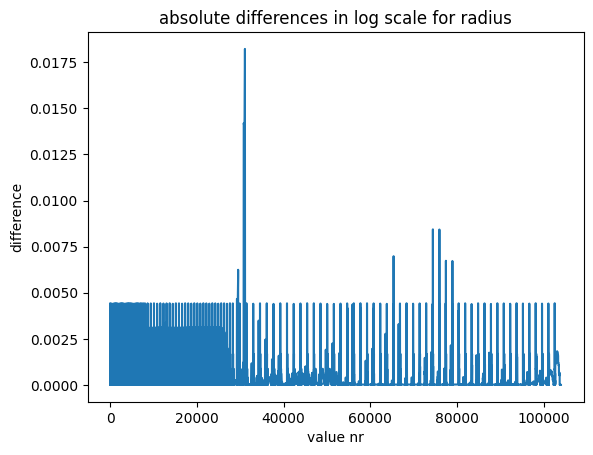

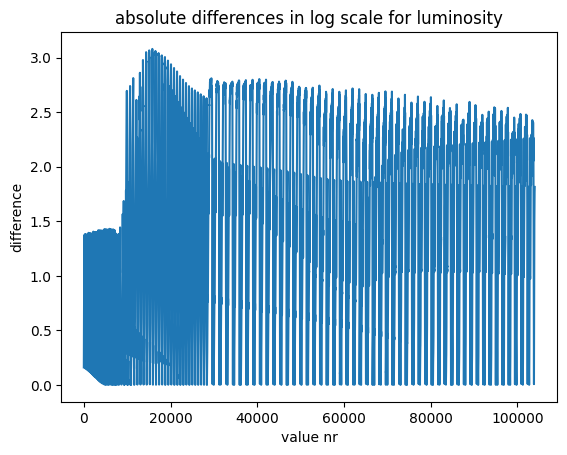

In [24]:
x = []
x2 = []

for res in result:
    x.append(res[2])
    x2.append(res[3])

plt.title("absolute differences in log scale for radius")
plt.xlabel("value nr")
plt.ylabel("difference")
plt.plot(x)
plt.show()

plt.title("absolute differences in log scale for luminosity")
plt.xlabel("value nr")
plt.ylabel("difference")
plt.plot(x2)
plt.show()

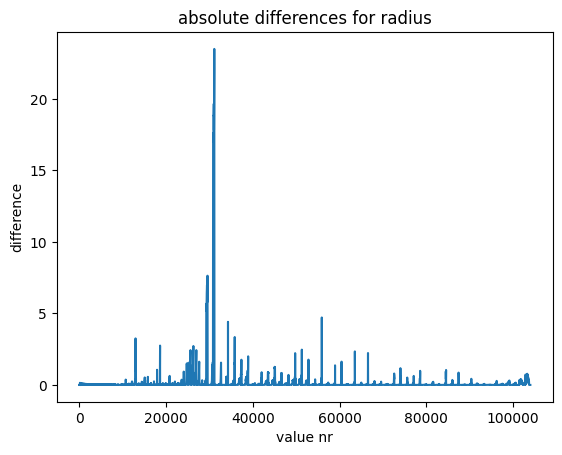

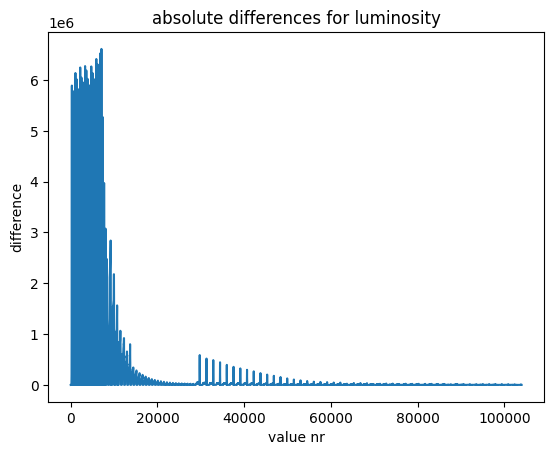

In [25]:
x = []
x2 = []

for res in result:
    x.append(res[0])
    x2.append(res[1])

plt.title("absolute differences for radius")
plt.xlabel("value nr")
plt.ylabel("difference")
plt.plot(x)
plt.show()

plt.title("absolute differences for luminosity")
plt.xlabel("value nr")
plt.ylabel("difference")
plt.plot(x2)
plt.show()

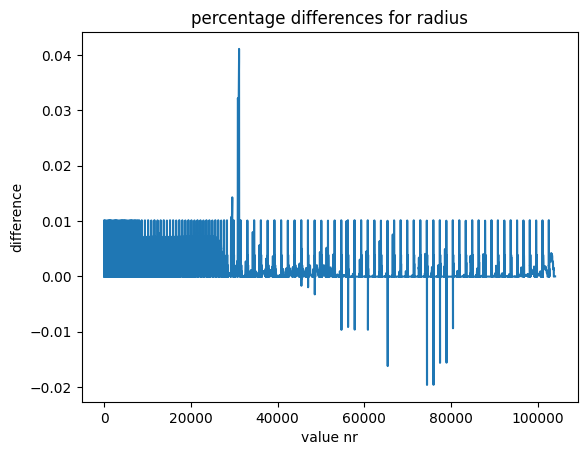

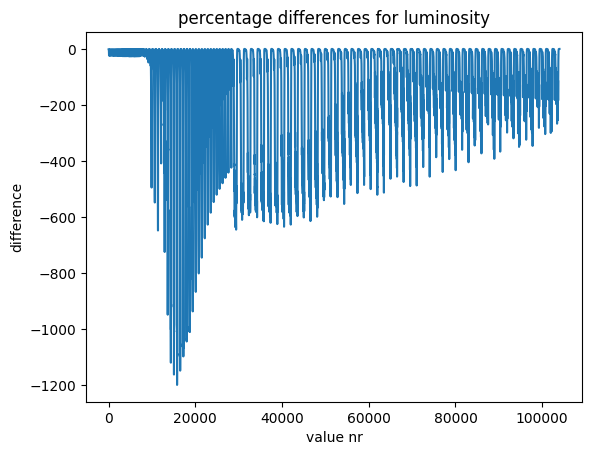

In [ ]:
x = []
x2 = []

for res in result:
    x.append(res[4])
    x2.append(res[5])

plt.title("Percentage differences for radius")
plt.xlabel("value nr")
plt.ylabel("difference")
plt.plot(x)
plt.show()

plt.title("Percentage differences for luminosity")
plt.xlabel("value nr")
plt.ylabel("difference")
plt.plot(x2)
plt.show()